In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata

In [26]:
df = pd.read_fwf('SUEWS_SiteSelect_sorted.txt')
df.columns=df.iloc[0]
df=df.reindex(df.index.drop(0))
df.drop(df.tail(2).index,inplace=True)
df= df.astype(float)
lat=df['lat']
lon=df['lng']

In [27]:
x_file='wrfinput_d03.suews'
ds_base = xr.open_dataset(x_file)
wrf_Y=ds_base.XLAT.values[0,:,:]
wrf_X=ds_base.XLONG.values[0,:,:]

In [28]:
def pc_plot(grid_x, grid_y,new_Z,name):
    plt.figure(figsize=(10,10))
    plt.pcolor(grid_x, grid_y,new_Z)
    plt.colorbar()
    plt.title(name)
    plt.ylabel('lat')
    plt.xlabel('lon')
    

In [29]:
def regrid_lower(name):
    Z=df[name]
    grid_x=wrf_X
    grid_y=wrf_Y
    new_Z=griddata(list(zip(lon,lat)), Z.values, (grid_x, grid_y), method='linear')
    #pc_plot(grid_x, grid_y,new_Z,name)
    return grid_x, grid_y,new_Z

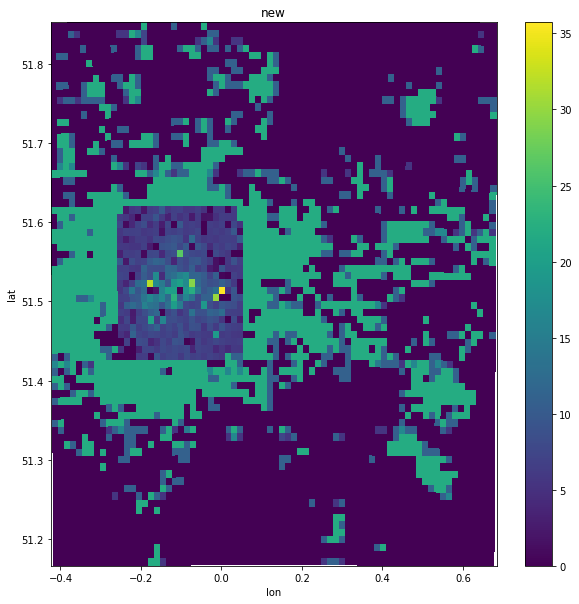

In [30]:
names=['H_Bldgs','H_EveTr','H_DecTr']
names_wrf=['bldgH_SUEWS','EveTreeH_SUEWS','DecTreeH_SUEWS']
#new_all={}

for name,name_wrf in zip(names,names_wrf):
    grid_x, grid_y,new_0=regrid_lower(name)
    #new_all.update( {name : new_0} )
    ds_var=ds_base[name_wrf.upper()].values[0,:,:]
    ds_var[~np.isnan(new_0)]=new_0[~np.isnan(new_0)]

    
    
#sum_all=0*new_all[names[0]]
#for key in new_all.keys():
#    sum_all=sum_all+new_all[key]
pc_plot(grid_x, grid_y,ds_base['bldgH_SUEWS'.upper()].values[0,:,:],'new')

In [31]:
names=['Fr_Paved' ,'Fr_Bldgs' ,'Fr_EveTr' ,'Fr_DecTr' ,'Fr_Grass' ,'Fr_Bsoil','Fr_Water']
new_all={}
for name in names:
    print(name)
    grid_x, grid_y,new_0=regrid_lower(name)
    new_all[name]=new_0

Fr_Paved
Fr_Bldgs
Fr_EveTr
Fr_DecTr
Fr_Grass
Fr_Bsoil
Fr_Water


In [32]:
new_0=new_all['Fr_Paved']
cd=~np.isnan(new_0)
ds_base['LANDUSEF'].values[0,12,:,:][cd]=new_all['Fr_Paved'][cd]+new_all['Fr_Bldgs'][cd]

ds_base['LANDUSEF'].values[0,0,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,1,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,4,:,:][cd]=new_all['Fr_EveTr'][cd]/3

ds_base['LANDUSEF'].values[0,2,:,:][cd]=new_all['Fr_DecTr'][cd]/2
ds_base['LANDUSEF'].values[0,3,:,:][cd]=new_all['Fr_DecTr'][cd]/2

ds_base['LANDUSEF'].values[0,5,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,6,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,7,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,8,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,9,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,11,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,13,:,:][cd]=new_all['Fr_Grass'][cd]/7

ds_base['LANDUSEF'].values[0,15,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,17,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,18,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,19,:,:][cd]=new_all['Fr_Bsoil'][cd]/4


ds_base['LANDUSEF'].values[0,10,:,:][cd]=new_all['Fr_Water'][cd]/2
ds_base['LANDUSEF'].values[0,16,:,:][cd]=new_all['Fr_Water'][cd]/2

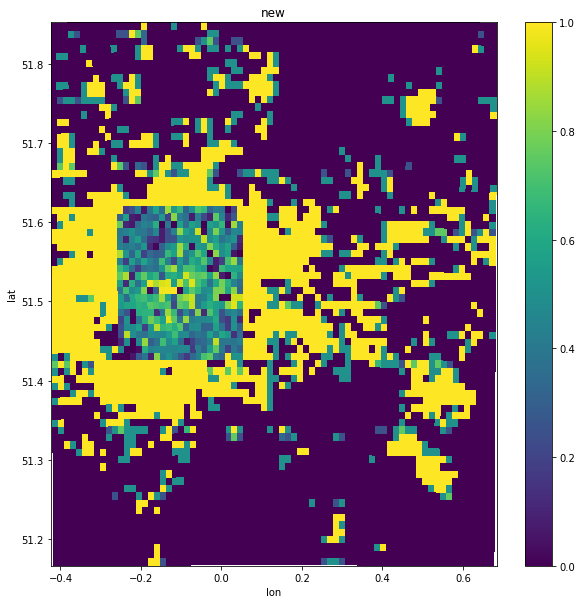

In [33]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,12,:,:],'new')

In [34]:
ds_merged = ds_base.update(ds_base)    

for var in ds_merged.data_vars.keys():
    if 'coordinates' in ds_merged[var].attrs:
        del ds_merged[var].attrs['coordinates']
        
file_out = x_file+'.new'

ds_merged.to_netcdf(file_out,
                    mode='w', format='NETCDF3_64BIT')
print('SUEWS input has beened added to:' + file_out)

SUEWS input has beened added to:wrfinput_d03.suews.new
